In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nivapy3 as nivapy
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

# warnings.filterwarnings("ignore")
plt.style.use("ggplot")

In [2]:
# Connect to NIVABASE
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


# ICPW Thematic Report 2020 - Nitrogen (Part 2: Annual trends)

Calculating annual trends for the nitrogen report. See the issue [here](https://github.com/JamesSample/icpw2/issues/1) for details.

## 1. Get stations

In [3]:
# Read stations
stn_path = r"../data/all_icpw_sites_may_2019.xlsx"
stn_df = pd.read_excel(stn_path, sheet_name="all_icpw_stns")

# Check stn numbers seem OK
trend_df = stn_df.query("group in ('Trends', 'Trends+Core')")
core_df = stn_df.query("group in ('Core', 'Trends+Core')")

print(f"There are {len(stn_df)} unique stations within the ICPW project as a whole.")
stn_df.head()

There are 556 unique stations within the ICPW project as a whole.


,station_id,station_code,station_name,latitude,longitude,altitude,continent,country,region,group
0,38115,Tr18_CA_DO1,Blue Chalk Lake,45.1999,-78.9432,344.0,North America,Canada,Ont,Trends
1,38116,Tr18_CA_DO2,Chub Lake,45.2138,-78.9836,343.0,North America,Canada,Ont,Trends
2,38117,Tr18_CA_DO3,Crosson Lake,45.0840,-79.0360,371.0,North America,Canada,Ont,Trends
3,38118,Tr18_CA_DO4,Dickie Lake,45.1510,-79.0876,379.0,North America,Canada,Ont,Trends
4,38119,Tr18_CA_DO5,Harp Lake,45.3798,-79.1335,327.0,North America,Canada,Ont,Trends


## 2. Extract raw chemistry data

In [4]:
# Specify time period of interest
st_dt = "1990-01-01"
end_dt = "2016-12-31"

# Get available parameters
par_df = nivapy.da.select_resa_station_parameters(stn_df, st_dt, end_dt, eng)
par_df

35 parameters available for the selected stations and dates.


,parameter_id,parameter_name,unit
0,65,ALK-E,µEq/l
1,50,Al,µg/l
2,223,As,µg/l
3,959,COLOUR,None
4,11,Ca,mg/l
5,15,Cd,µg/l
6,7,Cl,mg/l
7,225,Cr,µg/l
8,16,Cu,µg/l
9,879,DOC,mg/L C


In [5]:
# Get data
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(
    stn_df,
    [4, 5, 6, 24, 49],  # [TotN, NO3, TOC, TotP, NH4]
    st_dt,
    end_dt,
    eng,
    lod_flags=False,
    drop_dups=True,
)
wc_df.head()

WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



,station_id,station_code,station_name,sample_date,depth1,depth2,NH4-N_µg/l N,NO3-N_µg/l N,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P
,,,,,,,,,,,
0,23472,CH03,Lago di Tomè,1990-10-08,0.0,0.0,20.0,330.0,NaN,NaN,NaN
1,23472,CH03,Lago di Tomè,1993-08-18,0.0,0.0,30.0,490.0,NaN,NaN,NaN
2,23472,CH03,Lago di Tomè,1995-09-05,0.0,0.0,0.0,510.0,NaN,NaN,NaN
3,23472,CH03,Lago di Tomè,1995-09-15,0.0,0.0,0.0,450.0,NaN,NaN,NaN
4,23472,CH03,Lago di Tomè,1997-08-05,0.0,0.0,10.0,330.0,NaN,NaN,NaN


In [6]:
# Only consider samples within 1 m of surface
wc_df = wc_df.query("depth2 < 1")

## 3. Calculate derived parameters

In [7]:
# TON
wc_df["TON_µg/l N"] = (
    wc_df["TOTN_µg/l N"] - wc_df["NO3-N_µg/l N"] - wc_df["NH4-N_µg/l N"]
)

# TOTN/TOTP
wc_df["TOTN/TOTP"] = wc_df["TOTN_µg/l N"] / wc_df["TOTP_µg/l P"]

# NO3/TOTP
wc_df["NO3/TOTP"] = wc_df["NO3-N_µg/l N"] / wc_df["TOTP_µg/l P"]

# TOC/TON
wc_df["TOC/TON"] = 1000 * wc_df["TOC_mg C/l"] / wc_df["TON_µg/l N"]

# TOC/TOTP
wc_df["TOC/TOTP"] = 1000 * wc_df["TOC_mg C/l"] / wc_df["TOTP_µg/l P"]

In [8]:
# Save for speed
csv_path = r"./results/thematic_n_report_2020_working_data.csv"
wc_df.to_csv(csv_path, index=False, encoding="utf-8")

In [9]:
# Read saved data
csv_path = r"./results/thematic_n_report_2020_working_data.csv"
wc_df = pd.read_csv(csv_path, encoding="utf-8")
wc_df["sample_date"] = pd.to_datetime(wc_df["sample_date"], format="%Y-%m-%d")
wc_df.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,NH4-N_µg/l N,NO3-N_µg/l N,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,TON_µg/l N,TOTN/TOTP,NO3/TOTP,TOC/TON,TOC/TOTP
0,23472,CH03,Lago di Tomè,1990-10-08,0.0,0.0,20.0,330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23472,CH03,Lago di Tomè,1993-08-18,0.0,0.0,30.0,490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23472,CH03,Lago di Tomè,1995-09-05,0.0,0.0,0.0,510.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23472,CH03,Lago di Tomè,1995-09-15,0.0,0.0,0.0,450.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23472,CH03,Lago di Tomè,1997-08-05,0.0,0.0,10.0,330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Aggregate to annual medians

In [10]:
# Annual medians by station
wc_df["year"] = wc_df["sample_date"].dt.year
ann_df = wc_df.groupby(["station_id", "year"]).median().reset_index()

ann_df.head()

,station_id,year,depth1,depth2,NH4-N_µg/l N,NO3-N_µg/l N,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,TON_µg/l N,TOTN/TOTP,NO3/TOTP,TOC/TON,TOC/TOTP
0,23472,1990,0.0,0.0,20.0,330.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23472,1993,0.0,0.0,30.0,490.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23472,1995,0.0,0.0,0.0,480.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23472,1997,0.0,0.0,10.0,350.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23472,2000,0.0,0.0,23.0,506.262169,NaN,764.731,NaN,235.468831,NaN,NaN,NaN,NaN


## 5. Explore selection criteria

In [11]:
# Melt to long format
df = ann_df.copy()
del df["depth1"], df["depth2"]
df = pd.melt(df, id_vars=["station_id", "year"])
df.dropna(how="any", inplace=True)
df.head()

,station_id,year,variable,value
0,23472,1990,NH4-N_µg/l N,20.0
1,23472,1993,NH4-N_µg/l N,30.0
2,23472,1995,NH4-N_µg/l N,0.0
3,23472,1997,NH4-N_µg/l N,10.0
4,23472,2000,NH4-N_µg/l N,23.0


In [12]:
# Define selection criteria
n_start_thresh = 1  # Number of annual values in first 5 years
n_end_thresh = 1  # Number of annual values in last 5 years
prop_thresh = 0.65  # Proportion of total years with data

# Dict for results
inc_dict = {
    "station_id": [],
    "variable": [],
    "st_yr": [],
    "include": [],
}

# Loop over time series
for stn_id in df["station_id"].unique():
    # Loop over variables
    for par in df["variable"].unique():
        # Get data
        stn_par_df = df.query("(station_id == @stn_id) and (variable == @par)")
        stn_par_df.set_index("year", inplace=True)
        del stn_par_df["station_id"], stn_par_df["variable"]

        for st_yr in range(1990, 2006):

            # Years from st_yr to 2016
            years = range(st_yr, 2017)
            n_yrs = 2017 - st_yr
            yrs_thresh = round(n_yrs * prop_thresh)
            years_df = pd.DataFrame(index=years)

            # Resample to annual
            stn_par_yr_df = years_df.join(stn_par_df)

            if pd.isna(stn_par_yr_df["value"]).all().all():
                # Not suitable
                inc_dict["station_id"].append(stn_id)
                inc_dict["variable"].append(par)
                inc_dict["st_yr"].append(st_yr)
                inc_dict["include"].append(0)

            else:
                n_start = pd.notnull(
                    stn_par_yr_df[stn_par_yr_df.index < (st_yr + 5)]["value"]
                ).sum()
                n_end = pd.notnull(
                    stn_par_yr_df[stn_par_yr_df.index > (2011)]["value"]
                ).sum()
                non_missing = pd.notnull(stn_par_yr_df["value"]).sum()

                if (
                    (n_start >= n_start_thresh)
                    and (n_end >= n_end_thresh)
                    and (non_missing >= yrs_thresh)
                ):
                    # Include
                    inc_dict["station_id"].append(stn_id)
                    inc_dict["variable"].append(par)
                    inc_dict["st_yr"].append(st_yr)
                    inc_dict["include"].append(1)

                else:
                    # Not suitable
                    inc_dict["station_id"].append(stn_id)
                    inc_dict["variable"].append(par)
                    inc_dict["st_yr"].append(st_yr)
                    inc_dict["include"].append(0)

# Build df
inc_df = pd.DataFrame(inc_dict)

# Calculate bool cols describing presence of *combinations* of params
# Unstack to 'wide'
inc_df.set_index(["station_id", "variable", "st_yr"], inplace=True)
inc_df = inc_df.unstack("variable")
inc_df.columns = inc_df.columns.get_level_values(1)
inc_df.reset_index(inplace=True)

# Are all params present?
inc_df["TOC_TOTN_NO3"] = (
    (inc_df["TOC_mg C/l"] + inc_df["TOTN_µg/l N"] + inc_df["NO3-N_µg/l N"]) == 3
).astype(int)

inc_df["TOC_TOTN_NO3_NH4"] = (
    (
        inc_df["TOC_mg C/l"]
        + inc_df["TOTN_µg/l N"]
        + inc_df["NO3-N_µg/l N"]
        + inc_df["NH4-N_µg/l N"]
    )
    == 4
).astype(int)

# Melt back to 'long'
inc_df = inc_df.melt(id_vars=["station_id", "st_yr"], value_name="include",)

# Sum number of stations
nstns_df = inc_df.groupby(["variable", "st_yr"]).sum().reset_index()
nstns_df.rename({"include": "n_stns"}, inplace=True, axis="columns")
del nstns_df["station_id"]

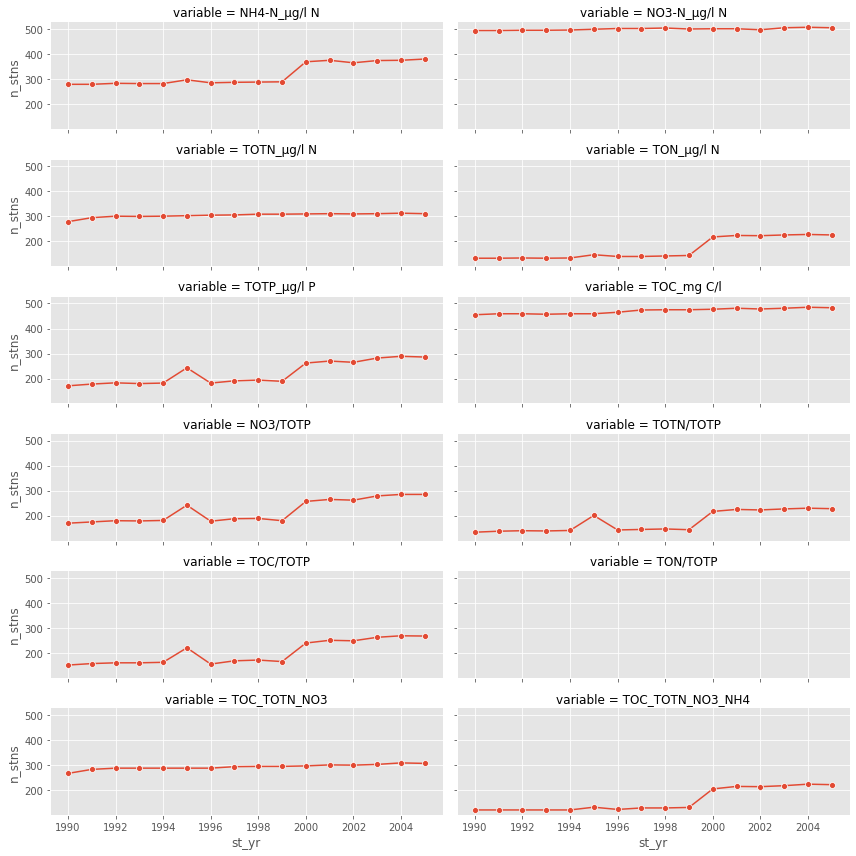

In [13]:
# Plot
sn.relplot(
    data=nstns_df,
    x="st_yr",
    y="n_stns",
    col="variable",
    col_wrap=2,
    aspect=3,
    height=2,
    kind="line",
    marker="o",
    col_order=[
        "NH4-N_µg/l N",
        "NO3-N_µg/l N",
        "TOTN_µg/l N",
        "TON_µg/l N",
        "TOTP_µg/l P",
        "TOC_mg C/l",
        "NO3/TOTP",
        "TOTN/TOTP",
        "TOC/TOTP",
        "TON/TOTP",
        "TOC_TOTN_NO3",
        "TOC_TOTN_NO3_NH4",
    ],
)

plt.savefig("./results/nstns_selected_by_styr.png", dpi=200)

## 5.1. Stations with TOC, TOTN, NO3 and NH4 from 2000

Kari would like to know which ~200 stations have time series for TOC, TOTN, NO3 and NH4 that *all* meet the selection criteria, beginning in 2000 (see e-mail received 03.04.2020 at 09.40).

In [14]:
# Get stations with "good" TOC, TOTN, NO3 and NH4 from 2000
stn_ids = inc_df.query(
    '(variable == "TOC_TOTN_NO3_NH4") and (st_yr == 2000) and (include == 1)'
)["station_id"].values

sel_stn_df = stn_df.query("station_id in @stn_ids")

# Save to CSV
csv_path = r"./results/icpw_stations_good_toc_totn_no3_nh4_from_2000.csv"
sel_stn_df.to_csv(csv_path, index=False)

# Map
nivapy.spatial.quickmap(
    sel_stn_df,
    popup="station_code",
    cluster=True,
    kartverket=True,
    aerial_imagery=True,
)

## 6. Approximating TON

### 6.1. Two methods for calculating TON

The map above shows a very restricted set of stations, with insufficient spatial coverage for the report. Looking at the plots above, if we're willing to ignore NH4 (i.e. calculate TON as TOTN - NO3), we would have around 300 sites to work with, rather than 200.

For the ~200 sites with data for TOC, TOTN, NO3 and NH4 from 2000, the code below calculates trends in two versions of TON:

 * TON = TOTN - NO3 - NH4
 * TON = TOTN - NO3
 
These are then compared to see if omitting NH4 has a noticable effect on the results. Kari has also suggested removing sites where long-term median NH4/NO3 > 0.1 and NH4/TOTN > 0.05 (see e-mail received 03.04.2020 at 11.16).

In [15]:
# Get data
cols = ["station_id", "year", "TOTN_µg/l N", "NO3-N_µg/l N", "NH4-N_µg/l N"]
ton_df = wc_df.query("station_id in @stn_ids")[cols].copy()

# Calc TON two ways
ton_df["TON_µg/l N"] = (
    ton_df["TOTN_µg/l N"] - ton_df["NO3-N_µg/l N"] - ton_df["NH4-N_µg/l N"]
)
ton_df["TON_Approx_µg/l N"] = ton_df["TOTN_µg/l N"] - ton_df["NO3-N_µg/l N"]

# Just TON
ton_df = ton_df[["station_id", "year", "TON_µg/l N", "TON_Approx_µg/l N"]]

# Set negative values to 0
for col in ["TON_µg/l N", "TON_Approx_µg/l N"]:
    ton_df[col].loc[ton_df[col] < 0] = 0

# Aggregate to annual medians
ton_df = ton_df.groupby(["station_id", "year"]).median().reset_index()

# Just 2000 or later
ton_df = ton_df.query("year >= 2000")

ton_df.head()

,station_id,year,TON_µg/l N,TON_Approx_µg/l N
10,23516,2000,63.0,147.0
11,23516,2001,37.5,171.5
12,23516,2002,32.5,114.0
13,23516,2003,76.0,140.0
14,23516,2004,0.0,160.0


### 6.2. Trends in TON

In [16]:
%%capture

# Dicts for results
res_dict = {
    "station_id": [],
    "variable": [],
    "mk_p_val": [],
    "mk_trend": [],
    "sen_slp": [],
    "sen_incpt": [],
    "sen_trend": [],
}

# Loop over stations
for stn_id in stn_ids:
    df = ton_df.query("station_id == @stn_id").copy()
    del df["station_id"]
    df.set_index("year", inplace=True)
    df.sort_index(inplace=True)

    # Setup plot
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

    # Loop over pars
    for idx, par in enumerate(["TON_µg/l N", "TON_Approx_µg/l N"]):
        # MK test
        mk_df = nivapy.stats.mk_test(df, par)

        # Sen's slope
        res_df, sen_df = nivapy.stats.sens_slope(df, value_col=par, index_col=df.index)

        # Add results to dict
        res_dict["station_id"].append(stn_id)
        res_dict["variable"].append(par)
        res_dict["mk_p_val"].append(mk_df.loc["p"].value)
        res_dict["mk_trend"].append(mk_df.loc["trend"].value)

        sslp = res_df.loc["sslp"].value
        sincpt = res_df.loc["icpt"].value
        res_dict["sen_slp"].append(sslp)
        res_dict["sen_incpt"].append(sincpt)
        res_dict["sen_trend"].append(res_df.loc["trend"].value)

        # Plot
        axes[idx].plot(sen_df.index, sen_df[par].values, "bo-")
        axes[idx].plot(sen_df.index, sen_df.index * sslp + sincpt, "k-")

        axes[idx].set_title(par)

    # Save plot
    plt.tight_layout()
    png_path = f"./results/ton_png/ton_stn_{stn_id}.png"
    plt.savefig(png_path, dpi=200)
    plt.close()

# Combine results
res_df = pd.DataFrame(res_dict)

In [17]:
res_df.head()

,station_id,variable,mk_p_val,mk_trend,sen_slp,sen_incpt,sen_trend
0,23516,TON_µg/l N,0.099126,no trend,2.322917,-4606.916667,no trend
1,23516,TON_Approx_µg/l N,0.387014,no trend,-1.353365,2848.557692,no trend
2,23597,TON_µg/l N,0.509484,no trend,-0.637500,1512.100000,no trend
3,23597,TON_Approx_µg/l N,0.187074,no trend,-1.142857,2536.857143,no trend
4,23598,TON_µg/l N,0.901650,no trend,-0.927083,2342.083333,no trend


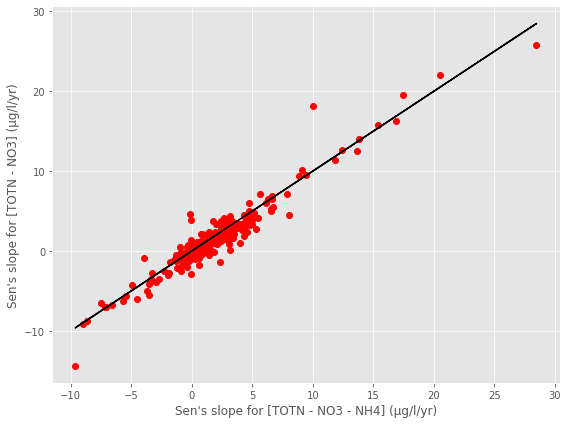

In [18]:
# Compare two ways of calculating TON
ss_df = res_df[["station_id", "variable", "sen_slp"]]
ss_df.set_index(["station_id", "variable"], inplace=True)
ss_df = ss_df.unstack("variable")
ss_df.columns = ss_df.columns.get_level_values(1)
ss_df.reset_index(inplace=True)

# Plot
fig = plt.figure(figsize=(8, 6))

plt.plot(
    ss_df["TON_µg/l N"], ss_df["TON_Approx_µg/l N"], "ro",
)

plt.plot(
    ss_df["TON_µg/l N"], ss_df["TON_µg/l N"], "k-",
)

plt.xlabel("Sen's slope for [TOTN - NO3 - NH4] (µg/l/yr)")
plt.ylabel("Sen's slope for [TOTN - NO3] (µg/l/yr)")
plt.tight_layout()

### 6.3. Median TON per site

See e-mail from Kari received 03.04.2020 at 17.02.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bcd2a8390>,
      dtype=object)

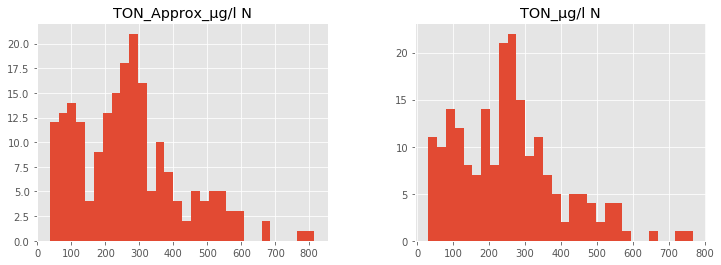

In [19]:
# Get data
cols = ["station_id", "year", "TOTN_µg/l N", "NO3-N_µg/l N", "NH4-N_µg/l N"]
ton_df = wc_df.query("station_id in @stn_ids")[cols].copy()

# Calc TON two ways
ton_df["TON_µg/l N"] = (
    ton_df["TOTN_µg/l N"] - ton_df["NO3-N_µg/l N"] - ton_df["NH4-N_µg/l N"]
)
ton_df["TON_Approx_µg/l N"] = ton_df["TOTN_µg/l N"] - ton_df["NO3-N_µg/l N"]

# Just TON
ton_df = ton_df[["station_id", "year", "TON_µg/l N", "TON_Approx_µg/l N"]]

# Set negative values to 0
for col in ["TON_µg/l N", "TON_Approx_µg/l N"]:
    ton_df[col].loc[ton_df[col] < 0] = 0

del ton_df["year"]

med_df = ton_df.groupby("station_id").median()

med_df.hist(bins=30, figsize=(12, 4))

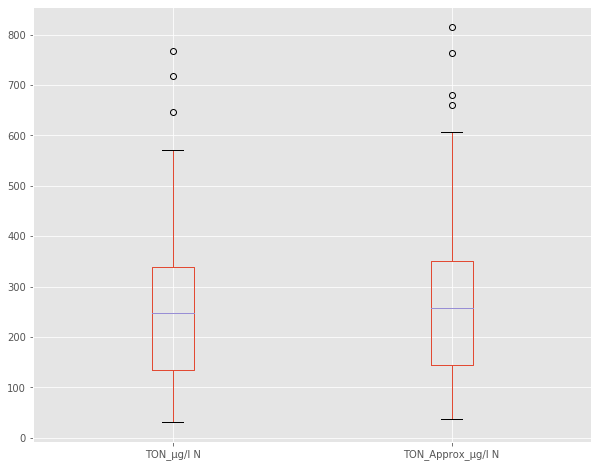

In [20]:
med_df.boxplot(figsize=(10, 8))

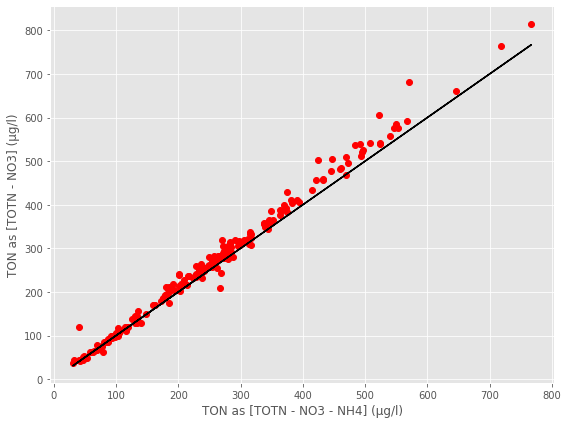

In [21]:
# Plot
fig = plt.figure(figsize=(8, 6))

plt.plot(
    med_df["TON_µg/l N"], med_df["TON_Approx_µg/l N"], "ro",
)

plt.plot(
    med_df["TON_µg/l N"], med_df["TON_µg/l N"], "k-",
)

plt.xlabel("TON as [TOTN - NO3 - NH4] (µg/l)")
plt.ylabel("TON as [TOTN - NO3] (µg/l)")
plt.tight_layout()

In [22]:
nstns_df.query('(variable == "TOC_TOTN_NO3") and (st_yr == 1992)')

,variable,st_yr,n_stns
82,TOC_TOTN_NO3,1992,287


## 7. Processing for selected stations

Based on the data exploration above, we have made the following decisions (see e-mail from Kari received 03.04.2020 at 17:02 and the issue [here](https://github.com/JamesSample/icpw2/issues/1) for details):

 * We will use the 287 stations where the records for TotN, NO3 and TOC all meet the selections criteria, beginning in 1992 
 
 * TON can be approximated as TotN - NO3
 
 * Trends for P will also be calculated for these stations, wherever the P time series also meets the selection criteria

### 7.1. Read raw data

In [23]:
# Read stations
stn_path = r"../data/all_icpw_sites_may_2019.xlsx"
stn_df = pd.read_excel(stn_path, sheet_name="all_icpw_stns")

# Check stn numbers seem OK
trend_df = stn_df.query("group in ('Trends', 'Trends+Core')")
core_df = stn_df.query("group in ('Core', 'Trends+Core')")

print(f"There are {len(stn_df)} unique stations within the ICPW project as a whole.")
stn_df.head()

There are 556 unique stations within the ICPW project as a whole.


,station_id,station_code,station_name,latitude,longitude,altitude,continent,country,region,group
0,38115,Tr18_CA_DO1,Blue Chalk Lake,45.1999,-78.9432,344.0,North America,Canada,Ont,Trends
1,38116,Tr18_CA_DO2,Chub Lake,45.2138,-78.9836,343.0,North America,Canada,Ont,Trends
2,38117,Tr18_CA_DO3,Crosson Lake,45.0840,-79.0360,371.0,North America,Canada,Ont,Trends
3,38118,Tr18_CA_DO4,Dickie Lake,45.1510,-79.0876,379.0,North America,Canada,Ont,Trends
4,38119,Tr18_CA_DO5,Harp Lake,45.3798,-79.1335,327.0,North America,Canada,Ont,Trends


In [24]:
# Read saved chem data
csv_path = r"./results/thematic_n_report_2020_working_data.csv"
wc_df = pd.read_csv(csv_path, encoding="utf-8")
wc_df["sample_date"] = pd.to_datetime(wc_df["sample_date"], format="%Y-%m-%d")
wc_df.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,NH4-N_µg/l N,NO3-N_µg/l N,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,TON_µg/l N,TOTN/TOTP,NO3/TOTP,TOC/TON,TOC/TOTP
0,23472,CH03,Lago di Tomè,1990-10-08,0.0,0.0,20.0,330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23472,CH03,Lago di Tomè,1993-08-18,0.0,0.0,30.0,490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23472,CH03,Lago di Tomè,1995-09-05,0.0,0.0,0.0,510.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23472,CH03,Lago di Tomè,1995-09-15,0.0,0.0,0.0,450.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23472,CH03,Lago di Tomè,1997-08-05,0.0,0.0,10.0,330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 7.2. Re-calculate TON and parameter ratios

As in section 3, but this time ignoring NH4.

In [25]:
# TON
wc_df["TON_µg/l N"] = wc_df["TOTN_µg/l N"] - wc_df["NO3-N_µg/l N"]

# TOTN/TOTP
wc_df["TOTN/TOTP"] = wc_df["TOTN_µg/l N"] / wc_df["TOTP_µg/l P"]

# NO3/TOTP
wc_df["NO3/TOTP"] = wc_df["NO3-N_µg/l N"] / wc_df["TOTP_µg/l P"]

# TOC/TON
wc_df["TOC/TON"] = 1000 * wc_df["TOC_mg C/l"] / wc_df["TON_µg/l N"]

# TOC/TOTP
wc_df["TOC/TOTP"] = 1000 * wc_df["TOC_mg C/l"] / wc_df["TOTP_µg/l P"]

### 7.3. Aggregate to annual medians

In [26]:
# Annual medians by station
wc_df["year"] = wc_df["sample_date"].dt.year
ann_df = wc_df.groupby(["station_id", "year"]).median().reset_index()

ann_df.head()

,station_id,year,depth1,depth2,NH4-N_µg/l N,NO3-N_µg/l N,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,TON_µg/l N,TOTN/TOTP,NO3/TOTP,TOC/TON,TOC/TOTP
0,23472,1990,0.0,0.0,20.0,330.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23472,1993,0.0,0.0,30.0,490.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23472,1995,0.0,0.0,0.0,480.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23472,1997,0.0,0.0,10.0,350.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23472,2000,0.0,0.0,23.0,506.262169,NaN,764.731,NaN,258.468831,NaN,NaN,NaN,NaN


### 7.4. Subset to stations and time period

In [27]:
# Melt to long format
df = ann_df.copy()
del df["depth1"], df["depth2"]
df = pd.melt(df, id_vars=["station_id", "year"])
df.dropna(how="any", inplace=True)
df.head()

,station_id,year,variable,value
0,23472,1990,NH4-N_µg/l N,20.0
1,23472,1993,NH4-N_µg/l N,30.0
2,23472,1995,NH4-N_µg/l N,0.0
3,23472,1997,NH4-N_µg/l N,10.0
4,23472,2000,NH4-N_µg/l N,23.0


In [28]:
# Define selection criteria
n_start_thresh = 1  # Number of annual values in first 5 years
n_end_thresh = 1  # Number of annual values in last 5 years
prop_thresh = 0.65  # Proportion of total years with data
st_yr = 1992  # Set period of interest (st_yr to 2016)

# Dict for results
inc_dict = {
    "station_id": [],
    "variable": [],
    "st_yr": [],
    "include": [],
}

# Loop over time series
for stn_id in df["station_id"].unique():
    # Loop over variables
    for par in df["variable"].unique():
        # Get data
        stn_par_df = df.query("(station_id == @stn_id) and (variable == @par)")
        stn_par_df.set_index("year", inplace=True)
        del stn_par_df["station_id"], stn_par_df["variable"]

        # Complete list of years
        years = range(st_yr, 2017)
        n_yrs = 2017 - st_yr
        yrs_thresh = round(n_yrs * prop_thresh)
        years_df = pd.DataFrame(index=years)

        # Resample to annual
        stn_par_yr_df = years_df.join(stn_par_df)

        if pd.isna(stn_par_yr_df["value"]).all().all():
            # Not suitable
            inc_dict["station_id"].append(stn_id)
            inc_dict["variable"].append(par)
            inc_dict["st_yr"].append(st_yr)
            inc_dict["include"].append(0)

        else:
            n_start = pd.notnull(
                stn_par_yr_df[stn_par_yr_df.index < (st_yr + 5)]["value"]
            ).sum()
            n_end = pd.notnull(
                stn_par_yr_df[stn_par_yr_df.index > (2011)]["value"]
            ).sum()
            non_missing = pd.notnull(stn_par_yr_df["value"]).sum()

            if (
                (n_start >= n_start_thresh)
                and (n_end >= n_end_thresh)
                and (non_missing >= yrs_thresh)
            ):
                # Include
                inc_dict["station_id"].append(stn_id)
                inc_dict["variable"].append(par)
                inc_dict["st_yr"].append(st_yr)
                inc_dict["include"].append(1)

            else:
                # Not suitable
                inc_dict["station_id"].append(stn_id)
                inc_dict["variable"].append(par)
                inc_dict["st_yr"].append(st_yr)
                inc_dict["include"].append(0)

# Build df
inc_df = pd.DataFrame(inc_dict)

# Calculate bool cols describing presence of *combinations* of params
# Unstack to 'wide'
inc_df.set_index(["station_id", "variable", "st_yr"], inplace=True)
inc_df = inc_df.unstack("variable")
inc_df.columns = inc_df.columns.get_level_values(1)
inc_df.reset_index(inplace=True)

# Are all params present?
inc_df["TOC_TOTN_NO3"] = (
    (inc_df["TOC_mg C/l"] + inc_df["TOTN_µg/l N"] + inc_df["NO3-N_µg/l N"]) == 3
).astype(int)

inc_df["TOC_TOTN_NO3_NH4"] = (
    (
        inc_df["TOC_mg C/l"]
        + inc_df["TOTN_µg/l N"]
        + inc_df["NO3-N_µg/l N"]
        + inc_df["NH4-N_µg/l N"]
    )
    == 4
).astype(int)

# Melt back to 'long'
inc_df = inc_df.melt(id_vars=["station_id", "st_yr"], value_name="include",)

In [29]:
# Get stations with "good" TOC, TOTN and NO3 from 1992
stn_ids = inc_df.query(
    '(variable == "TOC_TOTN_NO3") and (st_yr == @st_yr) and (include == 1)'
)["station_id"].values

sel_stn_df = stn_df.query("station_id in @stn_ids")
print(len(sel_stn_df), "stations selected.")

# Save to CSV
csv_path = f"./results/icpw_stations_good_toc_totn_no3_from_{st_yr}.csv"
sel_stn_df.to_csv(csv_path, index=False)

# Get annual data for stations and period
ann_df = ann_df.query("(year >= @st_yr) and (station_id in @stn_ids)")

# Map
nivapy.spatial.quickmap(
    sel_stn_df,
    popup="station_code",
    cluster=True,
    kartverket=True,
    aerial_imagery=True,
)

287 stations selected.


### 7.5. Calculate trends

In [33]:
%%capture

# Variables of interest
var_list = [
    "TOTN_µg/l N",
    "NO3-N_µg/l N",
    "TON_µg/l N",
    "TOC_mg C/l",
    "TOTP_µg/l P",
    "TOC/TON",
    "TOTN/TOTP",
    "NO3/TOTP",
    "TOC/TOTP",
]

# Dicts for results
res_dict = {
    "station_id": [],
    "variable": [],
    "median": [],
    "mk_p_val": [],
    "mk_trend": [],
    "sen_slp": [],
    "sen_incpt": [],
    "sen_trend": [],
}

# Loop over stations
for stn_id in stn_ids:
    df = ann_df.query("station_id == @stn_id").copy()
    del df["station_id"]
    df.set_index("year", inplace=True)
    df.sort_index(inplace=True)

    # Setup plot
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 16))
    axes = axes.flatten()
    fig.delaxes(axes[-1])

    # Loop over pars
    for idx, par in enumerate(var_list):
        # Determine whether to plot series
        inc = inc_df.query("(station_id == @stn_id) and (variable == @par)")[
            "include"
        ].values[0]

        if inc == 0:
            # Plot "omitted" text
            axes[idx].text(
                0.5,
                0.5,
                "Omitted due to lack of data",
                verticalalignment="center",
                horizontalalignment="center",
                transform=axes[idx].transAxes,
                fontsize=18,
            )
            axes[idx].set_title(par)

        else:
            # MK test
            mk_df = nivapy.stats.mk_test(df, par)

            # Sen's slope
            res_df, sen_df = nivapy.stats.sens_slope(
                df, value_col=par, index_col=df.index
            )

            # Add results to dict
            res_dict["station_id"].append(stn_id)
            res_dict["variable"].append(par)
            res_dict["median"].append(df[par].median())
            res_dict["mk_p_val"].append(mk_df.loc["p"].value)
            res_dict["mk_trend"].append(mk_df.loc["trend"].value)

            sslp = res_df.loc["sslp"].value
            sincpt = res_df.loc["icpt"].value
            res_dict["sen_slp"].append(sslp)
            res_dict["sen_incpt"].append(sincpt)
            res_dict["sen_trend"].append(res_df.loc["trend"].value)

            # Plot
            axes[idx].plot(sen_df.index, sen_df[par].values, "bo-")
            axes[idx].plot(sen_df.index, sen_df.index * sslp + sincpt, "k-")

            axes[idx].set_title(par)

    # Save plot
    plt.tight_layout()
    png_path = f"./results/trends_{st_yr}-2016/trends_{st_yr}-2016_stn_{stn_id}.png"
    plt.savefig(png_path, dpi=200)
    plt.close()

# Combine results
res_df = pd.DataFrame(res_dict)

# Save
csv_path = f"./results/trends_{st_yr}-2016/trends_{st_yr}-2016.csv"
res_df.to_csv(csv_path, index=False)

In [31]:
res_df.head()

,description,value
sslp,Median slope estimate,1.79028
icpt,Estimated intercept,-3531.32
lb,Lower bound on slope estimate at specified alpha,-1.21714
ub,Upper bound on slope estimate at specified alpha,8.09178
trend,Type of trend (if present),no trend
